# AutoDRIVE Eye Calibration

### Objectives:
* Calibrate the AutoDRIVE Eye to get its distortion coefficients, intrinsic parameters and extrinsic parameters.

### Theory:

Camera calibration computes the following parameters:
* Distortion coefficients
* Camera Intrinsic Parameters
    * Focal length
    * Optical centers
* Camera Extrinsic Parameters
    * Rotation vector
    * Translation vector
    
Following is a brief description of the process [1].

#### Distortion Coefficients

Some cameras introduce significant distortion to images. Two major kinds of distortion are radial distortion and tangential distortion.

Radial distortion causes straight lines to appear curved. Radial distortion becomes larger the farther points are from the center of the image. The amount of radial distortion can be represented as follows:

\begin{equation}
x_{distorted} = x( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\ y_{distorted} = y( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6) 
\end{equation}

Similarly, tangential distortion occurs because the image-taking lense is not aligned perfectly parallel to the imaging plane. So, some areas in the image may look nearer than expected. The amount of tangential distortion can be represented as below:

\begin{equation}
x_{distorted} = x + [ 2p_1xy + p_2(r^2+2x^2)] \\ y_{distorted} = y + [ p_1(r^2+ 2y^2)+ 2p_2xy]
\end{equation}

In short, we need to find five parameters, known as distortion coefficients given by:

\begin{equation}
dist = (k_1 \hspace{10pt} k_2 \hspace{10pt} p_1 \hspace{10pt} p_2 \hspace{10pt} k_3)
\end{equation}

#### Camera Intrinsic Parameters

Intrinsic parameters are specific to a camera. They include information like focal length ($f_x,f_y$) and optical centers ($c_x,c_y$). The focal length and optical centers can be used to create a camera matrix, which can be used to remove distortion due to the lenses of a specific camera. The camera matrix is unique to a specific camera, so once calculated, it can be reused on other images taken by the same camera. It is expressed as a $3 \times 3$ matrix:

\begin{equation}
mtx = \left [ \begin{matrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{matrix} \right ]
\end{equation}

#### Camera Extrinsic Parameters

Extrinsic parameters correspond to rotation and translation vectors, $r_{vecs}$ and $t_{vecs}$ respectively, which transform coordinates of a 3D point to a coordinate system.

### Implementation:

To find these parameters, we must provide some sample images of a well defined pattern (e.g. a chess board). We find some specific points of which we already know the relative positions (e.g. square corners in the chess board). We know the coordinates of these points in real world space and we know the coordinates in the image, so we can solve for the distortion coefficients. For better results, we need at least 10 test patterns.

The important input data needed for calibration of the camera is the set of 3D real world points, i.e. object points or `objpoints` and the corresponding 2D coordinates of these points in the image, i.e. image points or `imgpoints`. 

2D image points can be easily found from the image; these image points are locations where two black squares touch each other in chess boards.

However, it is not straightforward to compute the 3D real world points since the images are taken from a static camera and chess boards are placed at different locations and orientations. So we need to know (X,Y,Z) values. But for simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), we can pass the values as (0,0), (30,0), (60,0), ... Thus, we get the results in mm.

Once we get the `objpoints` and `imgpoints`, we can use them to calibrate the camera.

### Import Packages

In [1]:
import numpy as np
import cv2
import glob
import pickle
import collections
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Camera Calibration

Extract `objpoints` and `imgpoints` using images of calibration grid taken from the AutoDRIVE Eye.

In [2]:
cell_size = 0.07 # Size of the square cell (should not affect the result)
objp = np.zeros((6*9,3), np.float32) # Using a 6x9 grid image for calibration
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)*cell_size # Grid points

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Make a list of calibration images
images = glob.glob('Calibration Images/*.jpg')

# Step through the list and search for grid corners
for image in images:
    img = mpimg.imread(image)
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the grid corners
    ret, corners = cv2.findChessboardCorners(gray_img, (9,6),None)

    # If found, append object points and image points to the respective arrays
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Plot in a new window
        %matplotlib qt
        cv2.imshow('Corner Detection',img)
        cv2.waitKey(500) # Viewing delay in milliseconds

cv2.destroyAllWindows()

Use the `objpoints` and `imgpoints` to calibrate the camera for a specified `imgsize`.

In [3]:
img = mpimg.imread('Calibration Images/1.jpg') # Read in a test calibration image
img_size = (img.shape[1], img.shape[0]) # Get the image dimensions

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None) # Calibrate the camera

# Print the camera calibration result
print('Distortion Coefficients:')
print('dist = \n' + str(dist))
print('')

print('Camera Intrinsic Parameters:')
print('mtx = \n' + str(mtx))
print('')

print('Camera Extrinsic Parameters:')
print('rvecs = \n' + str(rvecs))
print('')
print('tvecs = \n' + str(tvecs))

# Save the camera calibration result for later use
camera_pickle = {}
camera_pickle["mtx"] = mtx
camera_pickle["dist"] = dist
camera_pickle["rvecs"] = rvecs
camera_pickle["tvecs"] = tvecs
pickle.dump(camera_pickle, open("AutoDRIVE_Eye_Parameters.p", "wb"))

Distortion Coefficients:
dist = 
[[ 9.23756159e-01 -1.17945651e+02 -6.67446753e-02 -1.17848226e-03
   3.83233666e+03]]

Camera Intrinsic Parameters:
mtx = 
[[3.15671852e+03 0.00000000e+00 3.59097908e+02]
 [0.00000000e+00 3.12952243e+03 2.39736909e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Camera Extrinsic Parameters:
rvecs = 
[array([[-0.00299818],
       [ 0.15304531],
       [ 0.01243984]]), array([[ 0.06492925],
       [ 0.04475003],
       [-0.0033811 ]]), array([[ 0.06615247],
       [-0.08026716],
       [ 0.01652551]]), array([[-0.08167321],
       [-0.094785  ],
       [ 0.01808626]]), array([[-0.06666413],
       [ 0.06211451],
       [ 0.00346809]]), array([[0.08617484],
       [0.11078508],
       [1.57809292]]), array([[ 0.00818341],
       [-0.06675504],
       [ 1.56671985]]), array([[-0.04606278],
       [-0.06185439],
       [ 1.59491363]]), array([[-0.07089128],
       [-0.03712647],
       [ 1.59476696]]), array([[-0.05816566],
       [ 0.03736426],
      

Undistort a test calibration image (sanity check).

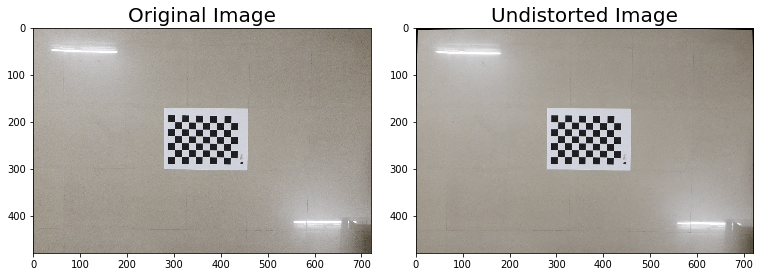

In [4]:
img = mpimg.imread('Calibration Images/1.jpg') # Read in a test calibration image
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx) # Generate the undistorted image

# Plot inline
%matplotlib inline
# View the results side-by-side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.0)
plt.show()

### References:
[1] OpenCV, "Camera Calibration," [Online]. Available: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html